Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [112]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [113]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [114]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))


Data size 17005207


In [115]:
print(words[:115])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 'interpretations', 'of', 'what', 'this', 'means', 'anarchism', 'also', 'refers', 'to', 'related', 'so

Build the dictionary and replace rare words with UNK token.

In [116]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:10])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [117]:
for i in data[:10]:
    print (i,reverse_dictionary[i])
    

5239 anarchism
3084 originated
12 as
6 a
195 term
2 of
3137 abuse
46 first
59 used
156 against


Function to generate a training batch for the skip-gram model.

In [121]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'originated', 'anarchism', 'term', 'term', 'of', 'as', 'originated']


Train a skip-gram model.

In [122]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [123]:
num_steps = 100001
avg_loss_skipgram = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
        avg_loss_skipgram.append(average_loss)
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.105930
Nearest to three: shady, nano, found, globalization, broadcast, executed, rhazes, marko,
Nearest to in: explains, constitutes, oceans, sadie, cyberpunk, estranged, triumphed, pesach,
Nearest to other: mis, zones, heh, pollination, nearer, amiable, ls, contexts,
Nearest to or: asch, wondered, nahuatl, callaghan, vocals, sheikh, retake, how,
Nearest to use: iv, steer, principia, microclimates, reelected, islander, franchise, scaly,
Nearest to five: wanderings, adulthood, leontopithecus, tasked, amerindian, detonate, spenser, allude,
Nearest to often: gre, organically, sociopathic, bald, mashal, herrmann, undirected, accidentals,
Nearest to world: job, specialisation, hadad, victors, mats, consisted, irrelevent, stunning,
Nearest to people: mud, staten, oint, bouncer, uan, fante, speedily, kazimierz,
Nearest to can: convocation, leibniz, khanum, henotheistic, microclimates, resign, phospholipids, metastasis,
Nearest to for: quotes, mousse, anti

In [124]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

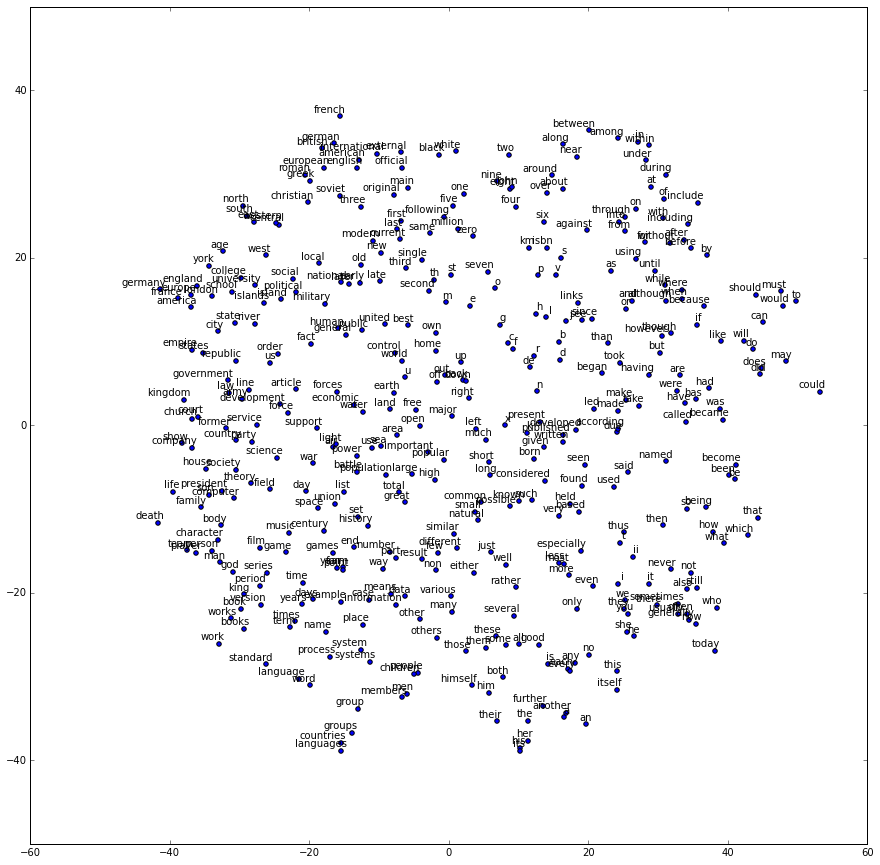

In [125]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

build the batch:

In [96]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    num_labels=batch_size/(span )    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(num_labels, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)

    #print ("num_labels",num_labels)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(num_labels):
       # print("i",i)
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        labels[i, 0] = buffer[target]
        for j in range(span-1):
            #print("j",j)
            while target in targets_to_avoid:
                #print ("target",buffer[target],"targets_to_avoid",targets_to_avoid, "skip_window",skip_window, "span",span,)
                target = random.randint(0, span - 1)
                #print("newTarget",target)
            targets_to_avoid.append(target)
            batch[i * (span-1) + j] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])
skip_win=1
for skip_win in [2,4]:
    batch, labels = generate_batch(8, num_skips=2, skip_window = skip_win)
    print ("batch shape:",batch.shape,"labels shape:",np.shape(labels))
    for i in range(8):
        print (" {}({})->{}({})".format(reverse_dictionary[batch[i]],batch[i],
                                        reverse_dictionary[labels[i/(2*skip_win), 0]],labels[i/(2*skip_win), 0]))
 
print("\ngenerate_batch: ready")

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
batch shape: (8,) labels shape: (2, 1)
 a(6)->as(12)
 anarchism(5239)->as(12)
 term(195)->as(12)
 originated(3084)->as(12)
 originated(3084)->a(6)
 as(12)->a(6)
 of(2)->a(6)
 term(195)->a(6)
batch shape: (8,) labels shape: (1, 1)
 early(128)->working(742)
 radicals(10572)->working(742)
 class(477)->working(742)
 the(1)->working(742)
 first(46)->working(742)
 used(59)->working(742)
 including(134)->working(742)
 against(156)->working(742)

generate_batch: ready


build the graph

In [97]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 1 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

## General defines
context_window = 2 * skip_window
num_labels = batch_size / context_window


graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[num_labels, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    
    # seq_ids only needs to be generated once so do this as a numpy array rather than a tensor.
    seq_ids = np.zeros(batch_size, dtype=np.int32)
    cur_id = -1
    for i in range(batch_size):
        if i % context_window == 0:
            cur_id = cur_id + 1
        seq_ids[i] = cur_id
    #print (seq_ids)
  
    # use segment_sum to add together the related words and reduce the output to be num_labels in size.
    final_embed = tf.segment_sum(embed, seq_ids)
  

    softmax = tf.nn.sampled_softmax_loss(softmax_weights, 
                                         softmax_biases, 
                                         final_embed,
                                         train_labels, 
                                         num_sampled, 
                                         vocabulary_size)
    
    loss = tf.reduce_mean(softmax)

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
print ("Graph: ready")

Graph: ready


run the graph

In [98]:
num_steps = 100001
avg_loss_cbow = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
        avg_loss_cbow.append(average_loss)

      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
print("graph: ran")

Initialized
Average loss at step 0: 8.258963
Nearest to have: bittersweet, affected, ceremony, watchful, ramesh, captained, stereo, containing,
Nearest to one: provocation, demeaning, roanoke, bhfuil, solve, pals, isopropyl, lyricist,
Nearest to such: kumasi, gambia, anaphase, fun, moncada, cordova, chari, sobieski,
Nearest to was: equivalency, fives, mourns, antennae, logarithmic, misogynist, ambulatory, eat,
Nearest to if: neil, reston, beatings, emphasizing, shreck, adb, miguel, w,
Nearest to more: hydrofoils, disengagement, annan, sensor, cassettes, encirclement, landslides, weston,
Nearest to their: pioneering, chinaman, raid, prefer, precede, coburg, koala, soured,
Nearest to other: diggers, dear, pumped, logan, triumphal, commemorative, asher, watchtower,
Nearest to or: calvinball, tendons, insurer, terminate, transfiguration, meetings, mejid, sled,
Nearest to people: jody, fluctuate, penis, nebulae, falsified, eclipse, infested, universals,
Nearest to years: witches, norman, jo

Example:

In [120]:
similarity.eval(dictionary['king']-dictionary['male']+dictionary['female'])


ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

run the tsne:

In [109]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

and finally plot it

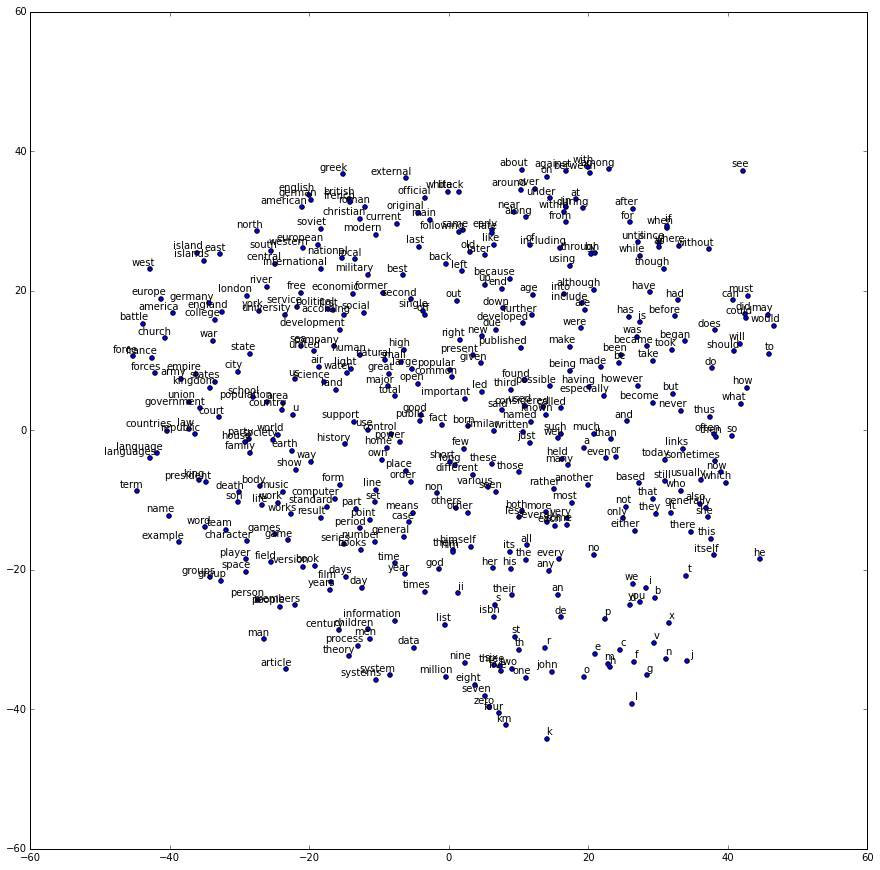

In [110]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

Compare skipgram vs cbow

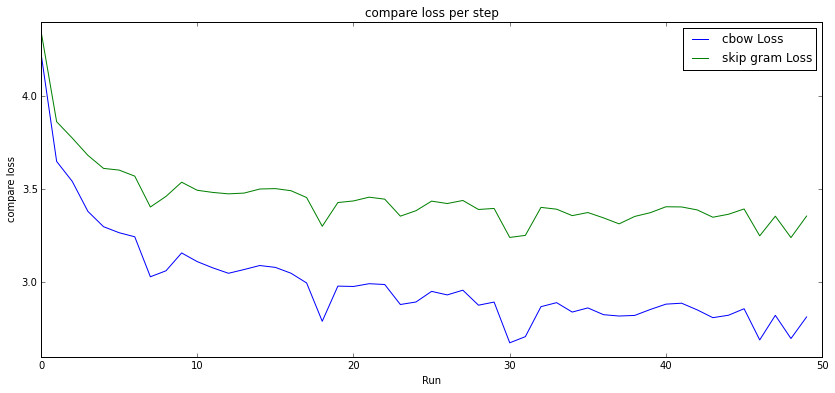

test accuracy:
0 4.23231873935 4.35168193388
1 3.6504783559 3.86387781358
2 3.54313155079 3.77600063396
3 3.38201468456 3.68320309466
4 3.2995488295 3.61296327603
5 3.26714915782 3.6037895236
6 3.24517913496 3.57137768292
7 3.03022075224 3.40536135942
8 3.06247157606 3.46245445371
9 3.1582913996 3.53869963133
10 3.1117336399 3.49530629587
11 3.07798961473 3.4836659919
12 3.04899040389 3.47611334473
13 3.06926314563 3.48022340816
14 3.09074562392 3.50205754504
15 3.0807187534 3.50422497439
16 3.04928101471 3.49293863678
17 2.9970130043 3.45624598324
18 2.79087212092 3.30179504329
19 2.98008376187 3.42926417464
20 2.97807787824 3.437968867
21 2.99297918087 3.45822472209
22 2.98868508339 3.44751193333
23 2.88116501716 3.35616171134
24 2.8946906347 3.38548156393
25 2.9517601203 3.43693414187
26 2.93272722912 3.42398924673
27 2.95809253699 3.44045617843
28 2.87748686081 3.39205824405
29 2.89423799501 3.39763151824
30 2.67529318562 3.24172309244
31 2.70834191456 3.25278449583
32 2.8695353385

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure(figsize=(14,6))
plt.plot(avg_loss_cbow[:],label="cbow Loss")
plt.plot(avg_loss_skipgram[:],label="skip gram Loss")
plt.xlabel('Run')
plt.ylabel('compare loss')
plt.legend()
plt.title("compare loss per step ")
plt.show()
plt.close()

print("test accuracy:")
for i in range(len(avg_loss_cbow)):
    print(i, avg_loss_cbow[i],avg_loss_skipgram[i])

###EOF